## How to plot 3 point time delay estimation velocity field

###### This jupyter notebook shows how to use a 3 point time delay estimation method and how to plot the resulting velocity field for Alcator C-Mod.

###### Documentation for the velocity estimation method can found here: https://github.com/uit-cosmo/velocity-estimation.

In [13]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import velocity_estimation.two_dim_velocity_estimates as tdve
import velocity_estimation.utils as u
from fppanalysis.running_moments import window_radius, run_norm_ds
import cosmoplots
import tde_functions

### Open dataset

###### Load APD data that is already extracted from the tree. 
###### Documentation on how to extract APD data from Alcator C-Mod can be found here: https://github.com/sajidah-ahmed/cmod_functions

In [2]:
shot = 1160616026
ds = xr.open_dataset("Path to your apd data")

### Extract dead pixels from mds tree

###### To extract array containing dead pixels directly from the tree, run ```dead_pixel_finder``` defined under tde_functions. 
###### If you want to save the array of dead pixels to your directory, specify the path to where you want to save these as input parameter "foldername" in ```dead_pixel_finder```.

In [14]:
dead_pix_arr = tde_functions.dead_pixel_finder(shot)

### Load dead pixels

###### If you have saved the array of dead pixels, load data

In [4]:
path_dead_pixel = Path('Path to your saved dead pixel data')
dead_pix = np.load(
    str(path_dead_pixel)
    + "/"
    + f"dead_pixels_shot_{shot}.npz"
)
dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way

### Remove dead pixels

###### We must remove data for those pixels that are dead. These pixels are set to NaN in the xarray dataset. 

In [ ]:
dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
for y in range(dead_pix_arr_ds.shape[0]):
    for x in range(dead_pix_arr_ds.shape[1]):
        if dead_pix_arr_ds[9-y, x]:
            ds['frames'].loc[dict(y=y, x=x)] = np.nan

### For a given start and end time, slice the dataset

In [6]:
t_start = 1.15
t_end = 1.45
sliced_ds = ds.sel(time=slice(t_start, t_end))

### Detrend data

###### Choose cut off frequency that corresponds to window size for the running normalization. To decide this frequency, you can look at the periodogram. 
###### ```run_norm_ds``` computes a running normalization for the entire xarray dataset, for a given radius of the window. 
###### Documentation on running normalization can be found here: https://github.com/uit-cosmo/fpp-analysis-tools/blob/main/fppanalysis/running_moments.py 

In [7]:
cut_off_freq = 1e3
radius = window_radius(cut_off_freq, sliced_ds.time)
ds = run_norm_ds(sliced_ds, radius)

### Extract LCFS and limiter positions from mds tree

###### To extract LCFS and limiter positions directly from mds tree, run ```LCFS_limiter_positions``` defined under tde_functions. The location of LCFS is not stationary, and an average is extracted in the function ```LCFS_limiter_positions```.
###### Input parameter ```num_time_steps``` is number of time sample points to extract LCFS location from. These number of points will be used to find min, max and mean LCFS locations. 

In [8]:
R_LCFS_mean, R_LCFS_min, R_LCFS_max, Z_LCFS, R_limiter, Z_limiter = tde_functions.LCFS_limiter_positions(
    shot, 
    t_start, 
    t_end, 
    num_time_steps=50, 
    foldername=None
)

shot 1160616026 is complete


### Load LCFS and limiter positions

###### If LCFS and limiter positions are already extracted from the tree, load data from a given path

In [ ]:
# Load LCFS and limiter data
LCFS_limiter_data = np.load("Path to your apd LCFS and limiter data")
R_limiter = LCFS_limiter_data['R_limiter']
Z_limiter = LCFS_limiter_data['Z_limiter']
R_LCFS = LCFS_limiter_data['R_LCFS']
Z_LCFS = LCFS_limiter_data['Z_LCFS']
R_LCFS_mean = LCFS_limiter_data['R_LCFS_mean']
R_LCFS_min = LCFS_limiter_data['R_LCFS_min']
R_LCFS_max = LCFS_limiter_data['R_LCFS_max']

### Estimation options for velocity estimation

###### Estimation parameters are set in the EstimationOptions class, which is accepted as an argument of ```estimate_velocity_field()```.

In [15]:
eo = tdve.EstimationOptions()

###### By default a cross-correlation based method is used to estimate time delays. This can be changed by setting EstimationOptions.method.

In [16]:
print(eo.method)

TDEMethod.CC


###### Further time delay estimation options are specified in EstimationOptions.cc_options. Default values are shown below

In [17]:
print(eo.cc_options)

CC Window: None, Minimum CC Value: 0, Running Mean: True, Running Mean Window Max: 7, Interpolate: False


###### To use 3 point method to estimate velocities from time delays set this to True, to use 2 point method set to False

In [18]:
eo.use_3point_method = True

###### If running mean is True, a custom running mean algorithm will be employed on the cross correlation function. The width of the running mean is selected as the minimum width such that the resulting signal has only 1 local maxima. The width cannot be larger than ```running_mean_window_max```

In [ ]:
eo.cc_options.running_mean = True

###### ```minimum_cc_value``` : Set a minimum cross correlation value needed to assign a velocity

In [ ]:
eo.cc_options.minimum_cc_value = 0

##### NeighbourOption class contains options to control neighbor selection. 
###### ```ccf_min_lag```: Integer, checks that the maximal correlation between adjacent pixels occurs at a time larger or equal than neighbors_ccf_min_lag multiples of the discretization time.
###### ```min_separation``` : minimum allowed separation between pixels
###### ```max_separation``` : maximum allowed separation between pixels
###### By default ```max_separation``` = ```min_separation``` = 1 which means that only nearest neighbour will be used

In [19]:
print(eo.neighbour_options)

CCF Min Lag: -1, Max Separation: 1, Min Separation: 1


In [20]:
eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=0)

### Generate velocities

###### ```estimate_velocity_field()``` will return a class containing estimated velocity data of all pixels.

In [21]:
movie_data = tdve.estimate_velocity_field(u.CModImagingDataInterface(ds), eo)
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()

/usr/local/lib/python3.10/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


### Plot velocity field

Text(0.59, 1.01, 'time = 1.15 - 1.45 s')

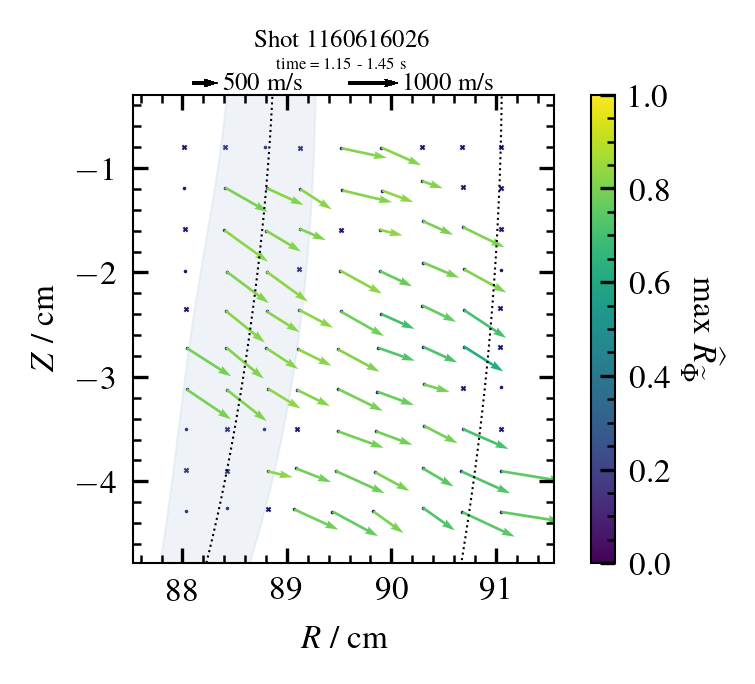

In [22]:
axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"

fig = plt.figure()
ax = fig.add_axes(axes_size)

# Mark dead and alive pixels
true_indices = np.where(dead_pix_arr)
false_indices = np.where(dead_pix_arr == False)
dead_pixels_R = R[true_indices]
dead_pixles_Z = Z[true_indices]
alive_pixels_R = R[false_indices]
alive_pixels_Z = Z[false_indices]

# Plot dead and alive pixels
ax.scatter(dead_pixels_R, dead_pixles_Z, marker='x', color='midnightblue', s=1, linewidth=0.5)
ax.scatter(alive_pixels_R, alive_pixels_Z, marker=".", color='midnightblue', s=0.5)

# Plot LCFS and limiter
ax.plot(R_LCFS_mean, Z_LCFS, color="black", linestyle=":", linewidth=0.5)
ax.plot(R_limiter, Z_limiter, color="black", linestyle=":", linewidth=0.5)
ax.fill_betweenx(
    Z_LCFS.ravel(),
    R_LCFS_min.ravel(),
    R_LCFS_max.ravel(),
    alpha=0.2,
    color="lightsteelblue",
)

# Define default vmin and vmax values for colorbar
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# Plot the velocity field
qiv = ax.quiver(
    R,
    Z,
    vx,
    vy,
    confidences,
    scale=210000,
    scale_units="xy",
    angles="xy",
    norm=norm,
)

# Plot arrows representing magnitude
qk = ax.quiverkey(
    qiv, 0.63, 1.025, 100000, r"$1000$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':6}, labelsep=0.02
)
qk = ax.quiverkey(
    qiv, 0.2, 1.025, 50000, r"$500$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':6}, labelsep=0.02
)

# Plot colorbar
cbar = fig.colorbar(qiv, format="%.1f")
cbar.ax.set_ylabel(r"max $\widehat{R}_{\widetilde{{\Phi}}}$", rotation=270, labelpad=13)

ax.set_xlabel(r"$R$ / cm")
ax.set_ylabel(r"$Z$ / cm")
ax.set_aspect("equal")
ax.set_ylim(min(Z[:,0]) - 0.5, max(Z[:,0] + 0.5))
ax.set_xlim([min(R[0]) - 0.5, max(R[0]) + 0.5])
plt.xticks(np.arange(round(min(R[0])), round(max(R[0]))+1, 1))
plt.yticks(np.arange(round(min(Z[:,0])), round(max(Z[:,0]))+1, 1))
ax.set_title(rf"Shot {shot}" , fontsize=6,  x=0.5, y=1.05)
plt.suptitle(r'time = 'f'{t_start} - {t_end} s', fontsize=4, horizontalalignment='center', x=0.59, y=1.01)


###### To save the figure

In [ ]:
format = "pdf"
filename = f"tde_{shot}.{format}"
foldername = "Path where you want to save figure"
fig.savefig(
    foldername + filename, bbox_inches="tight", format=format
)